# Lecture 12 
<!-- ToC -->

-Introduction: [>>](#Introduction)  
-The logistic map: [>>](#The-logistic-map)  
-Generating random numbers using numpy: [>>](#Generating-random-numbers-using-numpy)  
-More random number generators: [>>](#More-random-number-generators)  
--Poisson distribution: [>>](#Poisson-distribution)  
--Normal distribution: [>>](#Normal-distribution)  
-Monte Carlo models: [>>](#Monte-Carlo-models)  
--An aside - Gaussian approximation to Poisson distribution: [>>](#An-aside---Gaussian-approximation-to-Poisson-distribution)  
-Calculating pi using random numbers: [>>](#Calculating-pi-using-random-numbers)  

## Introduction

This week, we shall have a first look at how we can generate random numbers in Python programs and how these can be used to create Monte Carlo models and solve physical, mathematical and other problems.

## The logistic map

The logistic map provides a simple illustration of how computers can be used to generate random numbers, though, for reasons that will become obvious, the numbers it produces are not useful for Monte Carlo modelling.

The map is defined by the equation:

$$x_{n+1} = rx_n(1-x_n).$$

Here, $r$ is a parameter in the range $0 < r < 4,$ $x_n$ is the $n^{\rm th}$ and $x_{n+1}$ the $(n+1)^{\rm th}$ iteration of the map. Let's plot a number of values of the map for various values of $r$, starting with the initial value $x_0 = 0.75.$ We will look at $r$ = 1.3, 2.3, 3.3, 3.55 and 3.99 here. You can explore further values and the effects of changing the initial value yourselves!  

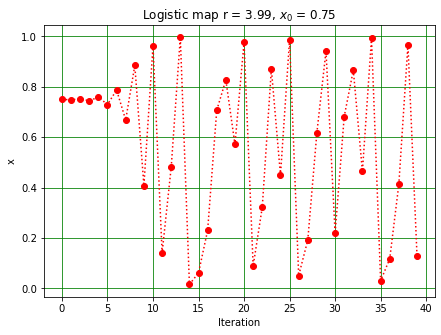

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#
def logMap(r, x):
    f = r*x*(1 - x)
    return f
#
xInA = 0.75
#r = 1.3
#r = 2.3
#r = 3.3
#r = 3.55
r = 3.99
nIts = 40
its = np.linspace(0, nIts - 1, nIts)
xValsA = np.zeros(nIts)
xValsA[0] = xInA
#
for n in range(1, nIts):
    xValsA[n] = logMap(r, xValsA[n - 1])
#
plt.figure(figsize = (7, 5))
plt.title("Logistic map r = " + str(r) + ", $x_0$ = " + str(xInA))
plt.plot(its, xValsA, color = 'r', marker = 'o', linestyle = ":")
plt.xlabel('Iteration')
plt.ylabel('x')
plt.grid(color = 'g')
plt.show()

We see that, for the first two $r$ values, $x_n$ tends to a constant value as $n$ increases. For $r = 3.3$, $x_n$ oscillates between two values after the first few iterations and for $r = 3.55$ it oscillates between four values, while, when $r = 3.9$, successive values of $x_n$ have no discernible pattern; they look (and generally are) random. We can look at the behaviour of the logistic map for various values of $r$ using the code below. Note that we are only plotting values of $x_n$ after the initial *transients* have died out (i.e. after the map has settled down into its steady state).

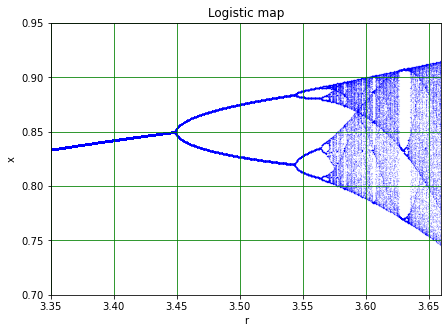

In [5]:
nRvals = 500
case = 1
if case == 0:
    rMin, rMax = 2.6, 4.0
elif case == 1:
    rMin, rMax = 3.35, 3.66
elif case == 2:
    rMin, rMax = 3.54, 3.59
elif case == 3:
    rMin, rMax = 3.563, 3.575
else:
    print("Set case to 0, 1, 2 or 3.")
    sys.exit()
#
rStep = (rMax - rMin)/nRvals
rArray = np.linspace(rMin, rMax, nRvals + 1)
#
nIters = 1000
mValues = np.zeros((nRvals + 1, nIters + 1))
#
mInit = 0.499
#
for n in range(0, nRvals + 1):
    mValues[n, 0] = mInit
    for m in range(1, nIters + 1):
        mValues[n, m] = logMap(rArray[n], mValues[n, m - 1])
#
nOmit = 500
fig, ax = plt.subplots(figsize = (7, 5))
plt.title("Logistic map")
for n in range(0, nRvals):
    plt.scatter(rArray[n]*np.ones(nIters + 1 - nOmit), mValues[n, nOmit:nIters + 1], 
                marker = '.', color = 'b', s = 0.01*(72./fig.dpi)**2)
plt.xlabel('r')
plt.ylabel('x')
plt.xlim(rMin, rMax)
if case == 0:
    plt.ylim(0.0, 1.0)
elif case == 1:
    plt.ylim(0.7, 0.95)
elif case == 2:
    plt.ylim(0.87, 0.90)
elif case == 3:
    plt.ylim(0.889, 0.894)
#
plt.grid(color = 'g')
plt.show() 

We see there is are values of $r$ for which the map appears to generate a sequence of random (or "chaotic") numbers. (In fact, the logistic map displays the period-doubling route to chaos and many other interesting features that go beyond the material we want to cover in this lecture, see [here](https://en.wikipedia.org/wiki/Logistic_map) for more information!) 

Why aren't these numbers useful for Monte Carlo models? To answer this question, let's look at the distribution of the numbers generated by the logistic map. (Run the cell above with `case = 0` first!)

Histogram bins start at 0.0 finish at 1.0
Number of bins is 20 and width of bins is 0.05
 
Value of r is 4.0


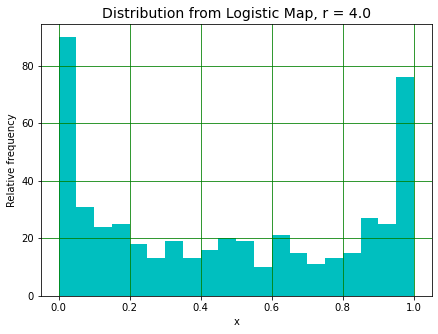

In [11]:
binBot = 0.0
binTop = 1.0
binNumber = 20
binEdges = np.linspace(binBot, binTop, binNumber + 1)
binWidth = (binTop - binBot)/binNumber
print("Histogram bins start at",binBot,"finish at",binTop)
print("Number of bins is",binNumber,"and width of bins is",binWidth)
#
nTplot = 500
print(" ")
print("Value of r is",rArray[nTplot])
randArr = mValues[nTplot, nOmit:nIters + 1]
#
plt.figure(figsize = (7, 5))
plt.title('Distribution from Logistic Map, r = ' + str(rArray[nTplot]), fontsize = 14)
plt.xlabel('x')
plt.ylabel('Relative frequency')
plt.hist(randArr, bins = binEdges, color = 'c')
plt.grid(color = 'g')
plt.show()

This distribution is not easily adapted to use in Monte Carlo models. Better would be a flat distribution, or one representing situations often encountered in physical and other problems, such as a Gaussian or Poisson distribution. We will look at how these can be generated and used below! 

## Generating random numbers using numpy

In the module `numpy.random`, Python provides a range of tools for generating random numbers. One of the most basic is a way of generating pseudo-random numbers in the $x$ interval $0 \le x \lt 1$, `numpy.random.rand`, and is described [here](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.rand.html#numpy.random.rand). We will look at this routine first, as it is a good way of seeing some of the properties of random number generators. It can be used as follows:

In [23]:
import numpy as np
#
# generate one random number
x = np.random.rand()
print("x = ",x)
#
# generate an array of 4 random numbers
x1D = np.random.rand(4)
print(" ")
print("x1D = \n",x1D)
#
# generate a 2D array containing 3 rows and 2 columns of random numbers 
x2D = np.random.rand(3, 2)
print(" ")
print("x2D = \n",x2D)

x =  0.2775498601794605
 
x1D = 
 [0.35501305 0.47905599 0.41318412 0.12150077]
 
x2D = 
 [[0.01978822 0.42190825]
 [0.75885709 0.81682834]
 [0.88749121 0.77560613]]


The routine `np.random.rand` uses the [Mersenne Twister algorithm](https://en.wikipedia.org/wiki/Mersenne_Twister), which (in the Numpy implementation) produces 53-bit precision `floats` and has a period of $2^{19937}-1$. The algorithm is started with a _seed_, analogous to the initial value we used when looking at the logistic map above. You will explore the effects of using different seed values in the computer class.

Now let's check that the distribution of numbers we get from `np.random.rand` is what we would expect.

Histogram bins start at 0.0 finish at 1.0
Number of bins is 10 and width of bins is 0.1


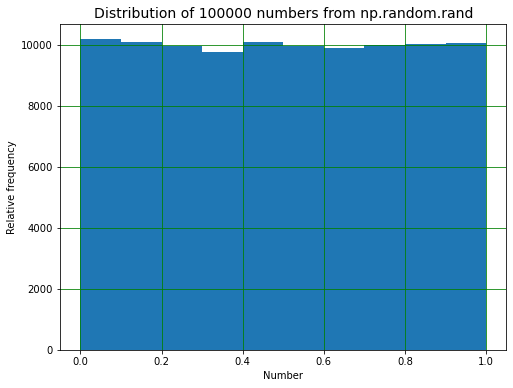

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
#
binBot = 0.0
binTop = 1.0
binNumber = 10
binEdges = np.linspace(binBot, binTop, binNumber + 1)
binWidth = (binTop - binBot)/binNumber
print("Histogram bins start at",binBot,"finish at",binTop)
print("Number of bins is",binNumber,"and width of bins is",binWidth)
#
nNumbers = 100000
randArr = np.random.rand(nNumbers)
#
plt.figure(figsize = (8, 6))
plt.title('Distribution of ' + str(nNumbers) + ' numbers from np.random.rand', fontsize = 14)
plt.xlabel('Number')
plt.ylabel('Relative frequency')
plt.hist(randArr, bins = binEdges)
plt.grid(color = 'g')
plt.show()

<!-- Student -->
## More random number generators

The random number generators available in `numpy.random` are described [here](https://docs.scipy.org/doc/numpy-1.15.0/reference/routines.random.html). We will look at two further generators. 

### Poisson distribution

The routine `random.poisson` produces numbers drawn from a Poisson distribution. This distribution occurs, for example, when the number of cars crossing a line on a road every minute is measured. If the average number per minute is 3.2, the numbers measured in the first, second, third etc. minutes could be 3, 3, 3, 4, 5, 2, 2, 5, 4 and 3. We see that, in contrast to `random.rand`, the numbers produced by `random.poisson` are integers. Their distribution can be shown in a histogram as below.

Histogram bins start at 0.0 finish at 10.0
Number of bins is 10 and width of bins is 1.0
randArr
 [3 2 5 8 2 1 2 2 4 5]


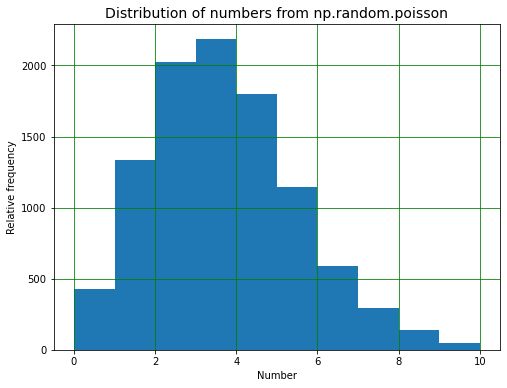

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
#
binBot = 0.0
binTop = 10.0
binNumber = 10
binEdges, binWidth = np.linspace(binBot, binTop, binNumber + 1, retstep = True)
print("Histogram bins start at",binBot,"finish at",binTop)
print("Number of bins is",binNumber,"and width of bins is",binWidth)
#
lam = 3.2
nEvents = 10000
randArr = np.random.poisson(lam, nEvents)
print("randArr\n",randArr[0:10])
#
plt.figure(figsize = (8, 6))
plt.title('Distribution of numbers from np.random.poisson', fontsize = 14)
plt.xlabel('Number')
plt.ylabel('Relative frequency')
plt.hist(randArr, bins = binEdges)
plt.grid(color = 'g')
plt.show()

<!-- Student -->
### Normal distribution

The Normal or Gaussian distribution is obtained using the routine `random.normal`. The numbers produced are floats, and the routine is used as below. 

Histogram bins start at -5.0 finish at 15.0
Number of bins is 20 and width of bins is 1.0
randArr
 [2.46   1.6986 4.6414 2.8941 5.5475]


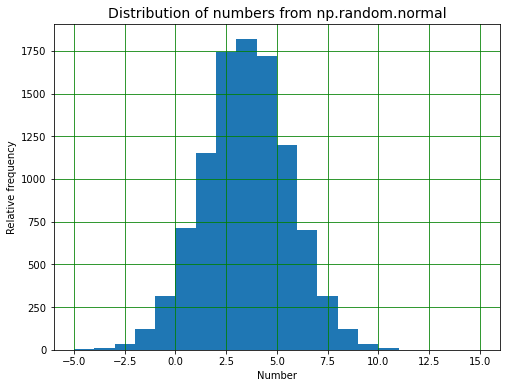

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
#
binBot = -5.0
binTop = 15.0
binNumber = 20
binEdges = np.linspace(binBot, binTop, binNumber + 1)
binWidth = (binTop - binBot)/binNumber
print("Histogram bins start at",binBot,"finish at",binTop)
print("Number of bins is",binNumber,"and width of bins is",binWidth)
#
mean = 3.5
RMS = 2.1
nEvents = 10000
randArr = np.random.normal(mean, RMS, nEvents)
np.set_printoptions(precision = 4)
print("randArr\n",randArr[0:5])
#
plt.figure(figsize = (8, 6))
plt.title('Distribution of numbers from np.random.normal', fontsize = 14)
plt.xlabel('Number')
plt.ylabel('Relative frequency')
plt.hist(randArr, bins = binEdges)
plt.grid(color = 'g')
plt.show()

<!-- Student -->
## Monte Carlo models

Random numbers can be used to produce computer models which descibe physics experiments or other problems. These are usually (for obvious reasons!) called Monte Carlo models. From the discussion above, it is clear that a simple example would be to use  the Poisson generator to model situations like the number of cars passing through the Mersey tunnel every minute, or the number of salmon swimming up a stream every day. If the average number in the required time interval is known, the Poisson distribution will give a sequence of numbers (of cars or fish) as expected in real life. A model based on this idea could then be used to find out if a queue is likely to form in the tunnel, or how many bears the stream is likely to be able to feed. (Interestingly, having caught their salmon, the bears retire to the nearest woods, eat most of their fish and indulge in another activity for which they are renowned. The resulting transfer of nutrients from stream to forest has been found to be essential to maintaining the local flora in some parts of the world - see the [Salmon Forest Project](http://web.uvic.ca/~reimlab/salmonforest.html) for more information!)

Let's look at a an example which is closer to home (note - the numbers used are fictitious!).

Records made by the Royal Liverpool Hospital staff show that, during the winter months, an average of 27 people require a bed in A&E each day. After one day, all A&E patients are moved to other wards. The hospital management have asked you to work out how many beds must be available to ensure that they never run out of spaces in A&E.

This statement is typical of how a question like this might be phrased, but it needs modification. One problem is the word "never". Even if the hospital were to have an enormous number of A&E beds, there will eventually be a day in which the number will turn out to be too small! Your first job is to persuade the management team that the question has to be how many beds do we need to make sure we don't run out of spaces on (say) 99.7% of days.

As shown below, we can use a Monte Carlo model to start to answer this question. What we are doing here is not realistic, as we are ignoring problems like the change in the average number of people needing a bed with weather conditions, the occurrence of Liverpool and Everton football matches, what happens when the other wards in the hospital are full and someone has to stay in A&E for two days etc. It does, however, illustrate how useful Monte Carlo modelling can be in this kind of situation.

First, generate the numbers of patients expected per day during one winter (91 days) and check that this looks sensible by plotting it!

Histogram bins start at 0.0 finish at 67
Number of bins is 16 and width of bins is 4.1875
Bin centres are:
 [ 2.0938  6.2812 10.4688 14.6562 18.8438 23.0312 27.2188 31.4062 35.5938
 39.7812 43.9688 48.1562 52.3438 56.5312 60.7188 64.9062]
 


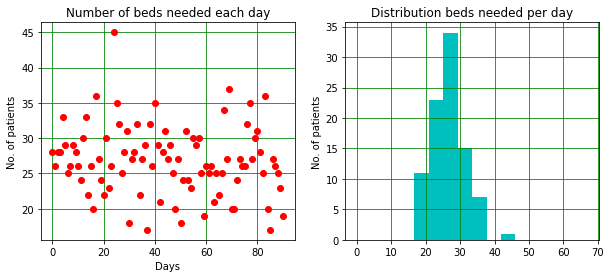

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#
# Average number of patients per day
nPatsDay = 27
#
# Nmber of days in winter
nDays = 91
tArray = np.linspace(0, nDays - 1, nDays)
#
# Number of patients per day (i.e. number of beds needed per day), assuming Poisson dist. 
patsPerDay = np.random.poisson(nPatsDay, nDays) 
#
# Plot number of beds needed each day and the distribution of number of beds needed per day
binBot = 0.0
binTop = int(2.5*nPatsDay)
binNumber = binTop//4
binEdges, binWidth = np.linspace(binBot, binTop, binNumber + 1, retstep = True)
binCentres = (binEdges[1:binNumber + 1] + binEdges[0:binNumber])/2 
print("Histogram bins start at",binBot,"finish at",binTop)
print("Number of bins is",binNumber,"and width of bins is",binWidth)
print("Bin centres are:\n",binCentres)
print(" ")
#
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Number of beds needed each day")
plt.xlabel("Days")
plt.ylabel("No. of patients")
plt.plot(tArray, patsPerDay, color = 'r', linestyle = '', marker = 'o')
plt.grid(color = 'g')
#
plt.subplot(1, 2, 2)
plt.title("Distribution beds needed per day")
plt.hist(patsPerDay, bins = binEdges, color = 'c')
plt.ylabel("Relative frequency")
plt.ylabel("No. of patients")
plt.grid(color = 'g')
#
plt.show()

<!-- Student -->
Now add up the number of beds needed each day and test how often the total exceeds the number available, for a range of numbers of available beds.

 
Number of beds available 	 No days one or more patients has no bed
		 0 				 91
		 5 				 91
		 10 				 91
		 15 				 91
		 20 				 80
		 25 				 57
		 30 				 18
		 35 				 4
		 40 				 1
		 45 				 0
		 50 				 0
		 55 				 0
		 60 				 0
		 65 				 0


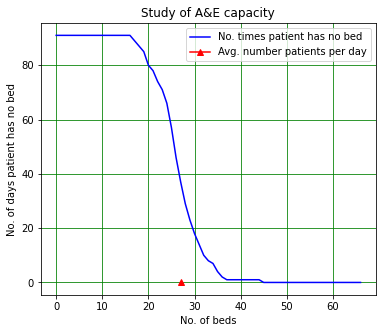

In [29]:
maxBedNumber = int(2.5*nPatsDay)
noBedArr = np.zeros(maxBedNumber)
print(" ")
print("Number of beds available \t No days one or more patients has no bed")
for nBeds in range(0, maxBedNumber):
    nWithoutBed = np.sum(patsPerDay > nBeds)
    noBedArr[nBeds] = nWithoutBed
    if nBeds%5 == 0:
        print("\t\t {:d} \t\t\t\t {:d}".format(nBeds, nWithoutBed))
#
bedNumberArr = np.linspace(0, maxBedNumber - 1, maxBedNumber)
#
plt.figure(figsize = (6, 5))
plt.title("Study of A&E capacity")
plt.xlabel("No. of beds")
plt.ylabel("No. of days patient has no bed")
plt.plot(bedNumberArr, noBedArr, color = 'b', label = "No. times patient has no bed")
plt.plot(nPatsDay, 0.0, color = 'r', marker = '^', label = "Avg. number patients per day")
plt.legend()
plt.grid(color = 'g')
plt.show()

<!-- Student -->
Both this plot and the histogram of the number of patients arriving per day show us that something like 35...45 beds are needed in this winter. But what happens next winter? And the winter after that? We need to extend the model to look at the situation over several years if we want to check that the number of occasions on which we run out of beds is small.

Histogram bins start at 0.0 finish at 67
Number of bins is 67 and width of bins is 1.0
Bin centres are:
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5
 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5
 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5
 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5]
 
Too few beds on 244 days in total of 91000 days (proportion 2.6813e-03).
That is, enough beds on 90756 days (proportion 9.9732e-01).
 


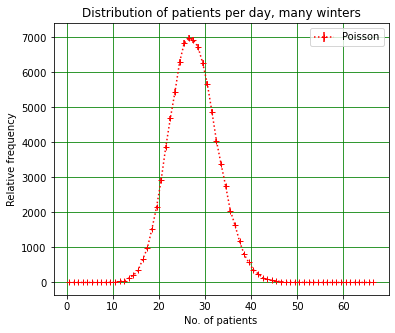

In [30]:
#
# Can use finer bins as have lots more events
binBot = 0.0
binTop = int(2.5*nPatsDay)
binNumber = binTop
binEdges, binWidth = np.linspace(binBot, binTop, binNumber + 1, retstep = True)
binCentres = (binEdges[1:binNumber + 1] + binEdges[0:binNumber])/2 
print("Histogram bins start at",binBot,"finish at",binTop)
print("Number of bins is",binNumber,"and width of bins is",binWidth)
print("Bin centres are:\n",binCentres)
#
nWinters = 1000
summedHist = np.zeros(binNumber)
#
for winter in range(0, nWinters):
    patsPerDay = np.random.poisson(nPatsDay, nDays)
    histThisWinter, bins = np.histogram(patsPerDay, bins = binEdges)
    summedHist = summedHist + histThisWinter
#
bedNumberArr = np.linspace(0, maxBedNumber - 1, maxBedNumber)
#
totalDays = nWinters*nDays
numberOfBeds = 43
daysTooFewBeds = np.sum(summedHist[numberOfBeds:maxBedNumber]).astype(int)
daysEnoughBeds = totalDays -  daysTooFewBeds
propTooFewBeds = daysTooFewBeds/totalDays
propEnoughBeds = daysEnoughBeds/totalDays
print(" ")
print("Too few beds on {:d} days in total of {:d} days (proportion {:5.4e}).".format(daysTooFewBeds, totalDays, propTooFewBeds))
print("That is, enough beds on {:d} days (proportion {:5.4e}).".format(daysEnoughBeds, propEnoughBeds))
print(" ")
#              
plt.figure(figsize = (6, 5))
plt.title("Distribution of patients per day, many winters")
plt.ylabel("Relative frequency")
plt.xlabel("No. of patients")
plt.errorbar(binCentres, summedHist/binWidth, yerr = np.sqrt(summedHist)/binWidth, 
             linestyle = ':', marker = '+', color = 'r', label = 'Poisson')
plt.grid(color = 'g')
plt.legend()
plt.show()

<!-- Student -->
Now we see that about $43$ beds are needed. In fact, as calculated above, with this number of beds the probablility of there being too few beds on a given day is about 0.3%.

### An aside - Gaussian approximation to Poisson distribution

The Poisson distribution with mean $\lambda$ looks very like a Gaussian with the same mean ($\mu = \lambda$) and  standard deviation $\sigma = \sqrt {\lambda}$. (This is true provided that $\lambda$ is not too small - a rule of thumb that is sometimes used is $\lambda > 20$, but what "too small" really means depends on the accuracy of the approximation you need!) We compare the two distributions in our case below:

 
Mean 27.000, RMS 5.196.
Mean + 3*RMS 42.588.
 


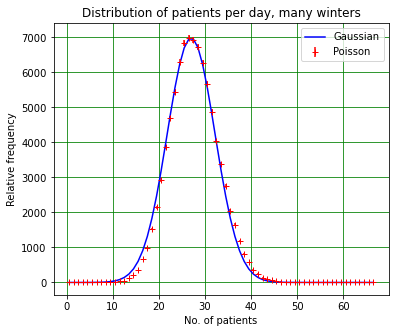

In [31]:
#
mean = nPatsDay
RMS = np.sqrt(nPatsDay)
norm = nWinters*nDays
gaussArr = norm/(np.sqrt(2*np.pi)*RMS)*np.exp(-(binCentres - mean)**2/(2*RMS**2))
print(" ")
print("Mean {:5.3f}, RMS {:5.3f}.".format(nPatsDay, RMS))
print("Mean + 3*RMS {:5.3f}.".format(nPatsDay+3*RMS))
print(" ")
#              
plt.figure(figsize = (6, 5))
plt.title("Distribution of patients per day, many winters")
plt.ylabel("Relative frequency")
plt.xlabel("No. of patients")
plt.errorbar(binCentres, summedHist/binWidth, yerr = np.sqrt(summedHist)/binWidth, 
             linestyle = '', marker = '+', color = 'r', label = 'Poisson')
plt.plot(binCentres, gaussArr, color = 'b', label = 'Gaussian')
plt.grid(color = 'g')
plt.legend()
plt.show()

The probability that $x$ lies within $3\sigma$ of the mean for a Gaussian $\rm{Prob}(\mu - 3\sigma < x < \mu + 3\sigma) = 0.9973$, so the probability of getting a result which is larger than the mean (i.e. the upper half of the distrubution only) by more than $3\sigma$ is $\frac{1 - 0.9973}{2} = 0.0013$. The number of $43$ beds is roughly $\mu + 3\sigma$, so we would expect the probability of there being too few beds to be roughly 0.13%. Given the approximations involved, the agreement with the above result is reasonable, and from the graph we can see that the Poisson distribution lies above the Gaussian approximation in the region around 40, so we would expect the 0.13% to be an underestimate, as is indeed the case.

<!-- Student -->
## Calculating pi using random numbers

Random numbers can be used to solve a large range of problems, including determining the value of $\pi$. This is a method that might have been used by ancient mathematicians in Persia...though I have no idea whether they actually tried it!

Spread out a square blanket of size $2 \times 2\,$m$^2$ on some flat ground. Mark out a circle of radius $1\,$m on the blanket, with the centre of the circle at the centre of the blanket. Now, from some distance, throw rice at the blanket so that the grains are spread uniformly over it. Count the grains that have fallen in the circle, $N_C$, and the total number of grains on the blanket, $N$. 

As the distribution of rice grains is uniform, the number in the circle and on the blanket is proportional to their respective areas. This means:

\begin{align*}
\frac{N_C}{N} &= \frac{\pi \times 1^2}{2 \times 2}\\ 
  &= \frac{\pi}{4}.
\end{align*}

We can therefore calculate the value of $\pi$ by dividing the number of grains in the circle by the number on the blanket and multiplying by $4$:

$$
\pi = 4\frac{N_C}{N}.
$$

As the only time rice is thrown in Liverpool is at weddings, where there aren't too many people whose primary interest is determining the value of $\pi$, we will use a random number generator to simulate this experiment.

In [34]:
# <!-- Student -->
#
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#
nGrains = 10000
riceX = np.random.rand(nGrains)
riceY = np.random.rand(nGrains)
riceR = np.sqrt(riceX**2 + riceY**2)
nCircle = np.sum(riceR < 1)
pi = 4*nCircle/nGrains
print(" ")
print("Number of grains on blanket {:d}, number in circle {:d}.".format(nGrains, nCircle))
print("Value of pi is approximately {:6.5f}".format(pi))

 
Number of grains on blanket 10000, number in circle 7804.
Value of pi is approximately 3.12160


It is of course important to know how accurate we expect this value of $\pi$ to be. You will determine the precision of the estimate in the computer classes! 